# U.S. Geological Survey Intro to MODFLOW Class
San Diego, CA\
January 6-10, 2025


## Background on the PEST++ Exercise Model

In [1]:
import os
import shutil
from pathlib import Path

import flopy as fp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyemu

### This exercise is based on the Basic MODFLOW class calibration exercise (except we will make use of PEST++). We will focus here on Prior Monte Carlo and the Iterative Ensemble Smoother. More complete tutorials on PEST++ are available at https://github.com/gmdsi/GMDSI_notebooks

### First let's load up the existing model and have a look

In [2]:
org_d = Path("../pest_background_files/")

In [3]:
sim = fp.mf6.MFSimulation.load(sim_ws=str(org_d))
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package chd...
    loading package rch...
    loading package riv...
    loading package wel...
    loading package obs...
  loading solution package at...


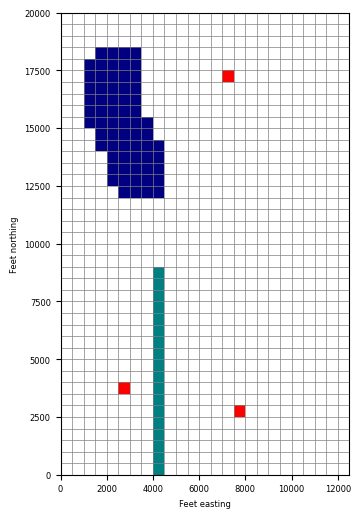

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
pmv = fp.plot.PlotMapView(m, ax=ax)
lc = pmv.plot_grid(lw=0.5)
pmv.plot_bc("WEL", plotAll=True, label="WEL")
pmv.plot_bc("RIV", plotAll=True, label="RIV")
pmv.plot_bc("CHD", plotAll=True, label="CHD")
ax.set_xlabel(f"{m.modelgrid.units.capitalize()} easting")
ax.set_ylabel(f"{m.modelgrid.units.capitalize()} northing")
ax.set_aspect(1)

# Before going any further, we should identify what is the forecast of interest?

The county is concerned about changes in streamflow and water levels due to the three proposed wells. None of these wells is active during the calibration period, but we have observations of the same categories of output so we should consider closely which aspects of the model to emphasize in our history matching efforts.

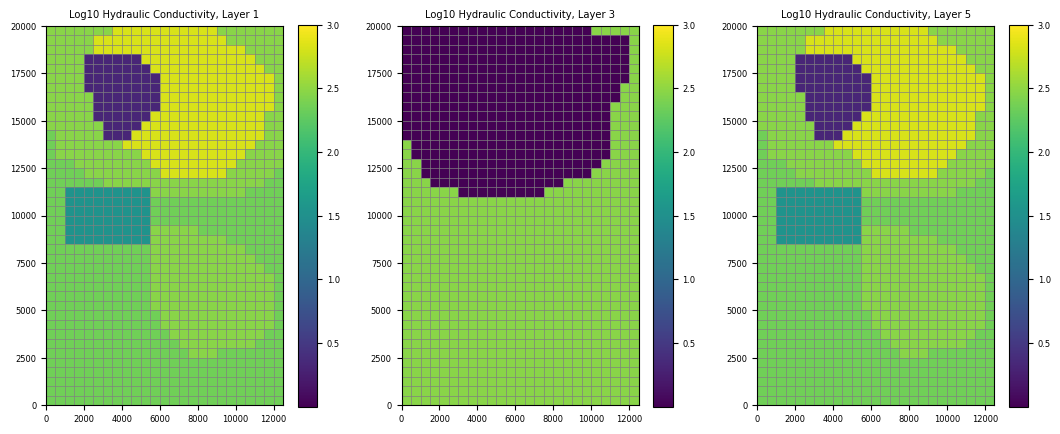

In [5]:
fig, allax = plt.subplots(1, 3, figsize=(13, 8))
for i, ax in zip([0, 2, 4], allax):
    pmv = fp.plot.PlotMapView(m, ax=ax)
    lc = pmv.plot_grid(lw=0.5)
    kp = pmv.plot_array(
        np.log10(m.npf.k.array[i]), zorder=0, vmin=0.001, vmax=3
    )
    fig.colorbar(kp, shrink=0.62)
    ax.set_aspect(1)
    ax.set_title(f"Log10 Hydraulic Conductivity, Layer {i+1}")

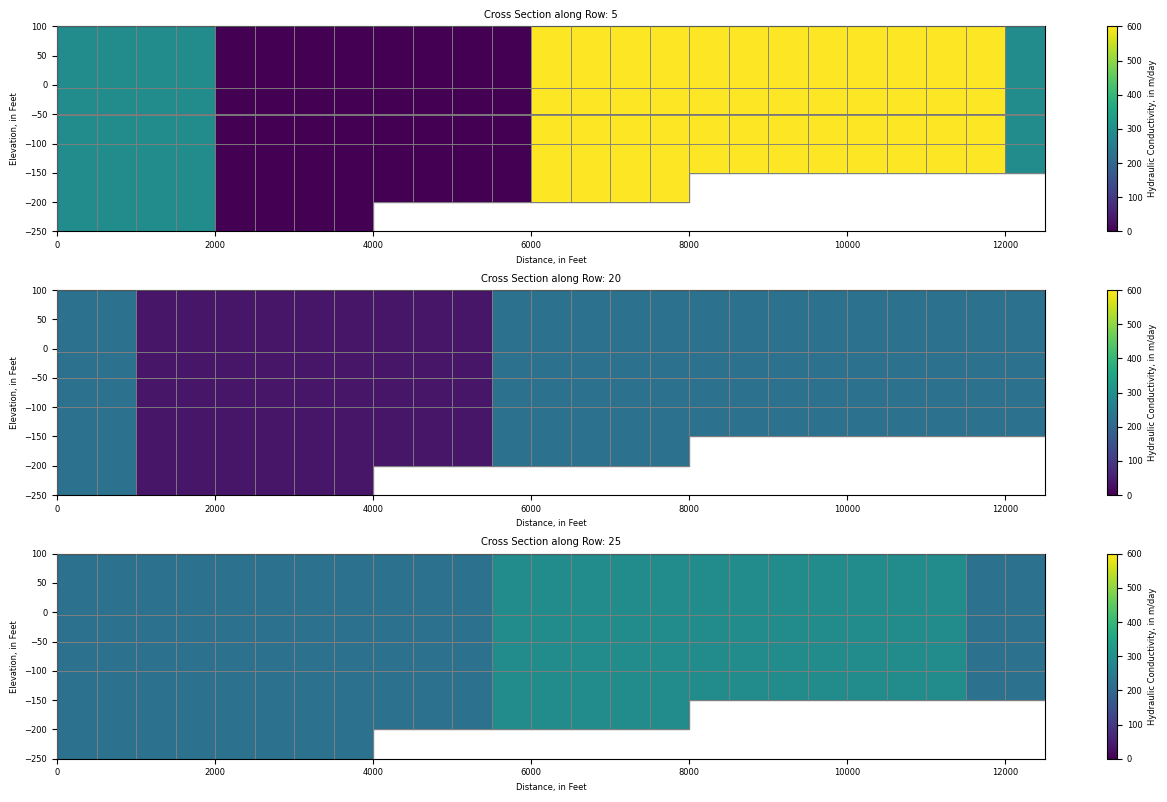

In [6]:
fig, allax = plt.subplots(3, 1, figsize=(13, 8))
for ax, row in zip(allax, [5, 20, 25]):
    xs = fp.plot.PlotCrossSection(model=m, line={"row": row}, ax=ax)
    lc = xs.plot_grid()
    xs.plot_bc("WEL")
    xs.plot_bc("RIV")
    xs.plot_bc("CHD")
    xs.plot_grid(lw=0.5, zorder=1e6)
    pc = xs.plot_array(m.npf.k.array, vmin=0, vmax=600)
    fig.colorbar(pc, label="Hydraulic Conductivity, in m/day")
    ax.set_xlabel(f"Distance, in {m.modelgrid.units.capitalize()}")
    ax.set_ylabel(f"Elevation, in {m.modelgrid.units.capitalize()}")
    ax.set_title(f"Cross Section along Row: {row}")
plt.tight_layout()

In [7]:
# Run the model to make sure there are outputs to look at
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../../miniforge3/envs/gmdsitut/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 12:21:01 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the

(True, [])

In [8]:
from flopy.utils.postprocessing import get_water_table

hds = m.output.head().get_data(kstpkper=(0, 0))
wt = get_water_table(hds)

cbc = m.output.budget()
riv = cbc.get_data(text="riv", full3D=True)[0]

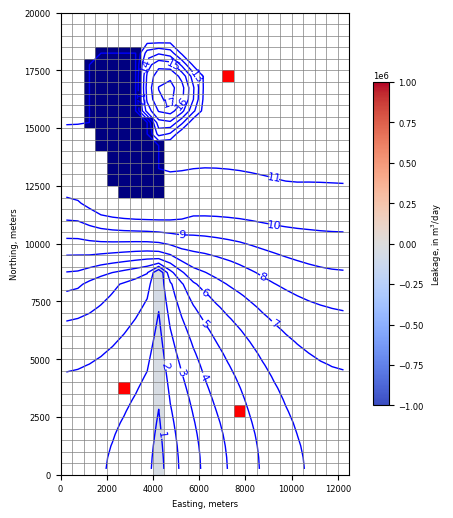

In [9]:
levels = np.arange(1, 20, 1)

fig, ax = plt.subplots(figsize=(6, 6))
pmv = fp.plot.PlotMapView(m, ax=ax)
ctr = pmv.contour_array(wt, levels=levels, linewidths=1, colors="b")
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -1e6, 1e6
lc = pmv.plot_grid(lw=0.5)
pmv.plot_bc("WEL", plotAll=True)
pmv.plot_bc("RIV", plotAll=True)
pmv.plot_bc("CHD", plotAll=True)
im = pmv.plot_array(riv.sum(axis=0), cmap="coolwarm", vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label="Leakage, in m$^3$/day")
ax.set_ylabel("Northing, meters")
ax.set_xlabel("Easting, meters")
ax.set_aspect(1)

## So this is the model - what kind of observations do we have?

In [10]:
# gotta get the cell locations
X, Y = m.modelgrid.xcellcenters, m.modelgrid.ycellcenters

In [11]:
# read in the river obs locations noting that they are aggregating
# along the river to the downstream locations for two gages
rivlox = pd.read_csv(
    org_d / "riv.riv",
    sep=r"\s+",
    header=None,
    names=["i", "j", "k", "dum0", "dum1", "dum2", "loc"],
)
rivob = (rivlox.groupby("loc")["j"].max() - 1).to_frame()
rivob["k"] = (rivlox["k"].unique() - 1)[0]
rivob["x"] = X[rivob.j, rivob.k]
rivob["y"] = Y[rivob.j, rivob.k]
rivob

,j,k,x,y
loc,,,,
ds,39,8,4250.0,250.0
pf,23,8,4250.0,8250.0


In [12]:
# now let's find the observation locations
# heads
obslox = pd.DataFrame.from_records(m.obs[2].continuous.data["at.csv"])
obslox["r"] = [i[1] for i in obslox.id]
obslox["c"] = [i[2] for i in obslox.id]
obslox["x"] = X[obslox.r, obslox.c]
obslox["y"] = Y[obslox.r, obslox.c]
obslox.sample(4)

# and make a subset dataframe for the 3 head difference targets
hdiff = obslox.loc[obslox.obsname.isin(["w02", "w08", "w15"])]

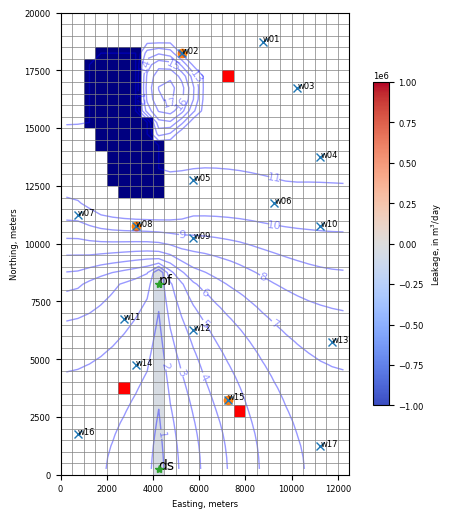

In [13]:
# Now for a bunch of boring plotting code...
levels = np.arange(1, 20, 1)

fig, ax = plt.subplots(figsize=(6, 6))
pmv = fp.plot.PlotMapView(m, ax=ax)
ctr = pmv.contour_array(wt, levels=levels, linewidths=1, colors="b", alpha=0.4)
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -1e6, 1e6
lc = pmv.plot_grid(lw=0.5)
pmv.plot_bc("WEL", plotAll=True)
pmv.plot_bc("RIV", plotAll=True)
pmv.plot_bc("CHD", plotAll=True)
im = pmv.plot_array(riv.sum(axis=0), cmap="coolwarm", vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label="Leakage, in m$^3$/day")
ax.plot(obslox.x, obslox.y, "x")
[
    ax.text(x, y, obsname)
    for x, y, obsname in zip(obslox.x, obslox.y, obslox.obsname)
]
ax.plot(hdiff.x, hdiff.y, "o", zorder=-1)
ax.plot(rivob.x, rivob.y, "*", zorder=100)
[
    ax.text(x, y, name, fontsize=10)
    for x, y, name in zip(rivob.x, rivob.y, rivob.index)
]
ax.set_ylabel("Northing, meters")
ax.set_xlabel("Easting, meters")
ax.set_aspect(1)

### Observations are:
- head observations at the X locations in both shallow and deep systems
- head differences at the orange filled locations
- two river flux observations at Pollock's Ford (pf) 
     and Downstream (ds)
- lake flux

### So we need to decide which parameters to estimate. Let's go with:
- Hydraulic conductivity in the aquifer (pilot points)
- Hydraulic conductivity in the clay intermediate unit (pilot points)
- K anisotropy in both
- riverbed conductance
- a uniform recharge value